In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


class CONFIG:
    """
    > General Options
    """

    # global seed
    seed = 42
    # the number of samples to use for testing purposes
    # if None, we use the full dataset
    samples_testing = None  # None
    # max rows to display for pandas dataframes
    display_max_rows = 100
    # name of the response variate we are trying to predict
    response_variate = "score"

    """
    > Preprocessing Options
    """
    # number of folds to split the data for CV
    num_folds = 5

    max_time_split = 20  # 13000
    time_split_len = 500
    """
    > Modelling Options
    """
    # whether to use optuna tuning or not
    # if False, then we load in pretuned weights for the LGBM models
    use_optuna_tuning = False
    # size of the test set for optuna tuning
    # if use_optuna_tuning=True
    test_size_optuna = 0.3
    # number of estimators to use for the boosting model
    num_estimators = 10000
    # number of trials to use for optuna tuning
    # if use_optuna_tuning=True
    num_trials_optuna = 50
    # number of trials to use for early stopping
    num_trials_early_stopping = 100

    """
    > Post-Modelling Options
    """
    # number of most important features to display
    # for the feature importances plot
    num_features_to_display = 50

# Import Utility Script & Libraries

In [2]:
import gc
import os
import random
import re
import statistics as st
import warnings
from collections import Counter

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from scipy.stats import kurtosis, skew
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.autonotebook import tqdm

/home/rohit/Desktop/kaggle/virtualenvs/writing_quality/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tqdm.pandas()

sns.set_style("whitegrid")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", CONFIG.display_max_rows)
warnings.simplefilter("ignore")

random.seed(CONFIG.seed)

# Load Data

In [4]:
INPUT_DIR = "./data"

train_logs = pd.read_csv(f"{INPUT_DIR}/train_logs.csv")
train_scores = pd.read_csv(f"{INPUT_DIR}/train_scores.csv")
test_logs = pd.read_csv(f"{INPUT_DIR}/test_logs.csv")

In [5]:
df_train = train_logs.merge(train_scores, on="id", suffixes=(None, None))

## Subsample Data (If Specified)

In [6]:
if CONFIG.samples_testing is not None:
    ids = list(train_logs["id"].unique())
    sample_ids = random.sample(ids, CONFIG.samples_testing)
    train_logs = train_logs[train_logs["id"].isin(sample_ids)]

In [7]:
train_logs.head()

id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1

In [8]:
train_logs.cursor_position.describe()

count    8.405898e+06
mean     1.222964e+03
std      9.485242e+02
min      0.000000e+00
25%      4.990000e+02
50%      1.043000e+03
75%      1.706000e+03
max      7.802000e+03
Name: cursor_position, dtype: float64

In [9]:
train_logs.action_time.describe()

count    8.405898e+06
mean     9.808498e+01
std      2.533985e+02
min      0.000000e+00
25%      6.600000e+01
50%      9.300000e+01
75%      1.220000e+02
max      4.474700e+05
Name: action_time, dtype: float64

<Axes: >

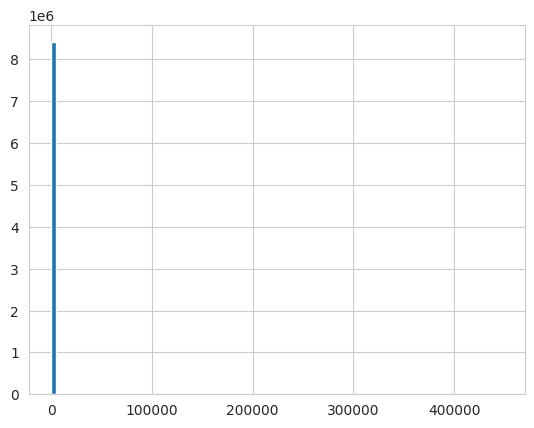

In [10]:
train_logs.action_time.hist(bins=100)

<Axes: >

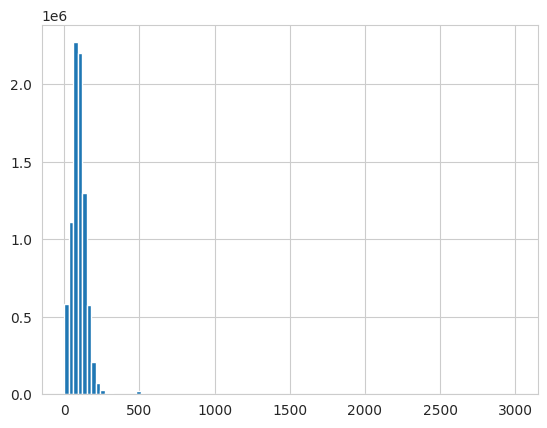

In [11]:
train_logs[train_logs.action_time <= 3000].action_time.hist(bins=100)

In [12]:
train_logs.down_time.describe()

count    8.405898e+06
mean     7.935603e+05
std      5.149451e+05
min      1.060000e+02
25%      3.731842e+05
50%      7.208860e+05
75%      1.163042e+06
max      8.313630e+06
Name: down_time, dtype: float64

<Axes: >

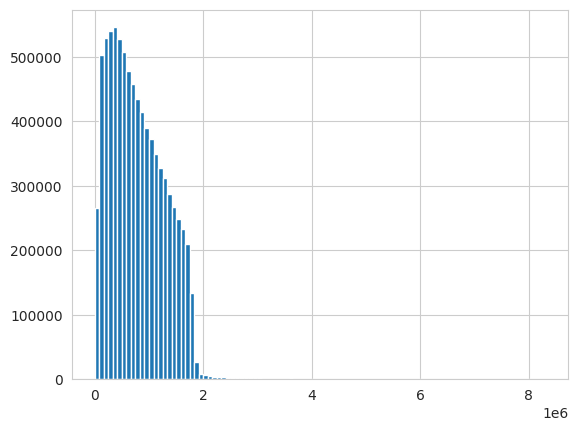

In [13]:
train_logs.down_time.hist(bins=100)

<Axes: >

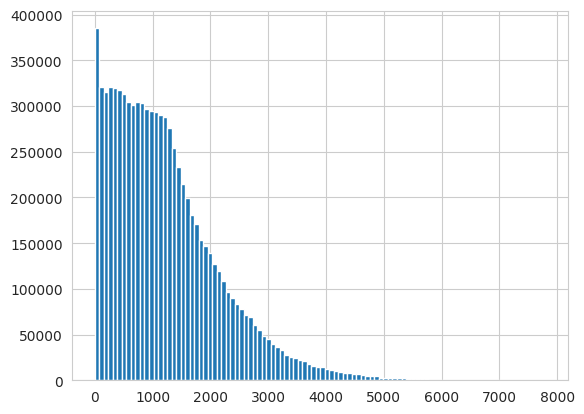

In [14]:
train_logs.cursor_position.hist(bins=100)

In [15]:
train_logs.action_time.quantile(0.99)

245.0

<Axes: >

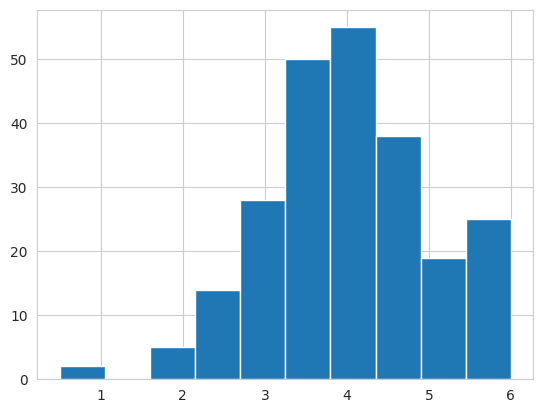

In [16]:
df_train[df_train.action_time > 5000][["id", "score"]].drop_duplicates().score.hist()

In [17]:
# def match_punctuations_time_split(df):
#         tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
#         punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
#                         '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
#         ret = list()
#         for li in tqdm(tmp_df['down_event'].values):
#             di = dict()
#             for time_split in range(CONFIG.max_time_split):
#                 split_li = li[time_split*CONFIG.time_split_len: (time_split+1)*CONFIG.time_split_len]
#                 cnt = 0
#                 items = list(Counter(split_li).items())
#                 for item in items:
#                     k, v = item[0], item[1]
#                     if k in punctuations:
#                         cnt += v
#                 di[f"punct_cnt_{time_split}"] = cnt
#             ret.append(di)
#         ret = pd.DataFrame(ret)
#         return ret

In [18]:
# _df = match_punctuations_time_split(train_logs)

In [19]:
# _df

In [20]:
def nunique_list(x):
    return len(set(x))

In [21]:
def mean_max_ratio_list(x):
    return st.mean(x) / max(x)

In [22]:
def word_added(x):
    return max(x) - min(x)

In [23]:
# _df = make_stats_features_time_split(train_logs)

In [24]:
# _df

# Feature Engineering

In [31]:
class Preprocessor:
    def __init__(self, seed):
        self.seed = seed

        self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
        self.events = [
            "q",
            "Space",
            "Backspace",
            "Shift",
            "ArrowRight",
            "Leftclick",
            "ArrowLeft",
            ".",
            ",",
            "ArrowDown",
            "ArrowUp",
            "Enter",
            "CapsLock",
            "'",
            "Delete",
            "Unidentified",
        ]
        self.text_changes = [
            "q",
            " ",
            "NoChange",
            ".",
            ",",
            "\n",
            "'",
            '"',
            "-",
            "?",
            ";",
            "=",
            "/",
            "\\",
            ":",
        ]
        self.punctuations = [
            '"',
            ".",
            ",",
            "'",
            "-",
            ";",
            ":",
            "?",
            "!",
            "<",
            ">",
            "/",
            "@",
            "#",
            "$",
            "%",
            "^",
            "&",
            "*",
            "(",
            ")",
            "_",
            "+",
        ]
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        # self.gaps = [1,5,10,15,30,50]
        # self.gaps = []

    #         self.gaps = [1, 2]

    def activity_counts_time_split(self, df):
        tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["activity"].values):
            di = dict()
            for time_split in range(CONFIG.max_time_split):
                split_li = li[
                    time_split
                    * CONFIG.time_split_len : (time_split + 1)
                    * CONFIG.time_split_len
                ]
                items = list(Counter(split_li).items())
                for k in self.activities:
                    di[f"{k}_{time_split}"] = 0
                for item in items:
                    k, v = item[0], item[1]
                    if f"{k}_{time_split}" in di:
                        di[f"{k}_{time_split}"] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [
            f"TS_activity_{i}_{k}_count"
            for k in range(CONFIG.max_time_split)
            for i in range(len(self.activities))
        ]
        ret.columns = cols
        return ret

    def activity_counts(self, df):
        tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["activity"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"activity_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def events_counts_time_split(self, df, colname):
        tmp_df = df.groupby("id").agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            di = dict()
            for time_split in range(CONFIG.max_time_split):
                split_li = li[
                    time_split
                    * CONFIG.time_split_len : (time_split + 1)
                    * CONFIG.time_split_len
                ]
                items = list(Counter(split_li).items())
                for k in self.events:
                    di[f"{k}_{time_split}"] = 0
                for item in items:
                    k, v = item[0], item[1]
                    if f"{k}_{time_split}" in di:
                        di[f"{k}_{time_split}"] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [
            f"TS_{colname}_{i}_{k}_count"
            for k in range(CONFIG.max_time_split)
            for i in range(len(self.events))
        ]
        ret.columns = cols
        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby("id").agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"{colname}_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def text_change_counts_time_split(self, df):
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["text_change"].values):
            di = dict()
            for time_split in range(CONFIG.max_time_split):
                split_li = li[
                    time_split
                    * CONFIG.time_split_len : (time_split + 1)
                    * CONFIG.time_split_len
                ]
                items = list(Counter(split_li).items())
                for k in self.text_changes:
                    di[f"{k}_{time_split}"] = 0
                for item in items:
                    k, v = item[0], item[1]
                    if f"{k}_{time_split}" in di:
                        di[f"{k}_{time_split}"] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [
            f"TS_text_change{i}_{k}_count"
            for k in range(CONFIG.max_time_split)
            for i in range(len(self.text_changes))
        ]
        ret.columns = cols
        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["text_change"].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f"text_change_{i}_count" for i in range(len(ret.columns))]
        ret.columns = cols
        return ret

    def match_punctuations_time_split(self, df):
        tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["down_event"].values):
            di = dict()
            for time_split in range(CONFIG.max_time_split):
                split_li = li[
                    time_split
                    * CONFIG.time_split_len : (time_split + 1)
                    * CONFIG.time_split_len
                ]
                cnt = 0
                items = list(Counter(split_li).items())
                for item in items:
                    k, v = item[0], item[1]
                    if k in self.punctuations:
                        cnt += v
                di[f"TS_punct_cnt_{time_split}"] = cnt
            ret.append(di)
        ret = pd.DataFrame(ret)
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df["down_event"].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({"punct_cnt": ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[
            (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
        ].reset_index(drop=True)
        tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
        tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
        tmp_df["text_change"] = tmp_df["text_change"].apply(
            lambda x: re.findall(r"q+", x)
        )
        tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
        tmp_df["input_word_length_mean"] = tmp_df["text_change"].apply(
            lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_max"] = tmp_df["text_change"].apply(
            lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df["input_word_length_std"] = tmp_df["text_change"].apply(
            lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
        )
        tmp_df.drop(["text_change"], axis=1, inplace=True)
        return tmp_df

    def make_stats_features_time_split(self, df):
        feats_stats = [
            # ("event_id", [max]),
            # ("up_time", [st.mean, st.stdev]),
            # ("up_time", [st.mean,max]),
            # ("down_time", [mean_max_ratio_list, st.stdev]),
            ("action_time", [sum]),
            # ("activity", [nunique_list]),  # nunique
            # ("down_event", [nunique_list]),
            # ("up_event", [nunique_list]),
            # ("text_change", [nunique_list]),
            # ("cursor_position", [st.mean,min,max,mean_max_ratio_list]),
            ("word_count", [word_added]),
        ]
        final_df = None
        for feats_stat in feats_stats:
            colname = feats_stat[0]
            methods = feats_stat[1]
            tmp_df = df.groupby("id").agg({colname: list}).reset_index()
            ret = list()
            for li in tqdm(tmp_df[colname].values):
                di = dict()
                for time_split in range(CONFIG.max_time_split):
                    split_li = li[
                        time_split
                        * CONFIG.time_split_len : (time_split + 1)
                        * CONFIG.time_split_len
                    ]
                    for method in methods:
                        try:
                            val = method(split_li)
                        except:
                            val = 0
                        di[
                            f"TS_{colname}_stat_{method.__name__}_split_{time_split}"
                        ] = val

                ret.append(di)

            ret_df = pd.DataFrame(ret)
            final_df = pd.concat([final_df, ret_df], axis=1)

        return final_df

    def make_feats(self, df):
        print("Remove outliers")
        df = df[df.action_time <= 7000].reset_index(drop=True)

        print("Starting to engineer features")

        # initialize features dataframe
        feats = pd.DataFrame({"id": df["id"].unique().tolist()})

        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
            df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
        df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"cursor_position_shift{gap}"] = df.groupby("id")[
                "cursor_position"
            ].shift(gap)
            df[f"cursor_position_change{gap}"] = (
                df["cursor_position"] - df[f"cursor_position_shift{gap}"]
            )
            df[f"cursor_position_abs_change{gap}"] = np.abs(
                df[f"cursor_position_change{gap}"]
            )
        df.drop(
            columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
        )

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
            df[f"word_count_change{gap}"] = (
                df["word_count"] - df[f"word_count_shift{gap}"]
            )
            df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
        df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)

        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]

        feats_stat = [
            ("event_id", ["max"]),
            ("up_time", ["max"]),
            ("action_time", ["sum", "max", "mean", "std"]),
            ("activity", ["nunique"]),
            ("down_event", ["nunique"]),
            ("up_event", ["nunique"]),
            ("text_change", ["nunique"]),
            ("cursor_position", ["nunique", "max", "mean"]),
            ("word_count", ["nunique", "max", "mean"]),
        ]
        for gap in self.gaps:
            feats_stat.extend(
                [
                    (f"action_time_gap{gap}", ["max", "min", "mean", "std", "sum"]),
                    (f"cursor_position_change{gap}", ["max", "mean", "std", "sum"]),
                    (f"word_count_change{gap}", ["max", "mean", "std", "sum"]),
                ]
            )

        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__

                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = (
                    df.groupby(["id"])
                    .agg({colname: method})
                    .reset_index()
                    .rename(columns={colname: f"{colname}_{method_name}"})
                )
                feats = feats.merge(tmp_df, on="id", how="left")

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        tmp_df = self.activity_counts_time_split(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering event counts data")
        tmp_df = self.event_counts(df, "down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, "up_event")
        feats = pd.concat([feats, tmp_df], axis=1)

        tmp_df = self.events_counts_time_split(df, "down_event")
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.events_counts_time_split(df, "up_event")
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        tmp_df = self.text_change_counts_time_split(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        tmp_df = self.match_punctuations_time_split(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering time split stat features")
        tmp_df = self.make_stats_features_time_split(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # input words
        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on="id", how="left")

        # compare feats
        print("Engineering ratios data")
        feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
        feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
        feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
        feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]

        # feats["word_action_time_mean_ratio"] = (
        #     feats["word_count_mean"] / feats["action_time_mean"]
        # )
        # feats["word_uptime_time_mean_ratio"] = (
        #     feats["word_count_mean"] / feats["up_time_mean"]
        # )
        # feats["word_down_time_mean_ratio"] = (
        #     feats["word_count_mean"] / feats["down_time_mean"]
        # )

        print("Done!")
        return feats

In [32]:
# class Preprocessor:
#     def __init__(self, seed):
#         self.seed = seed

#         self.activities = ["Input", "Remove/Cut", "Nonproduction", "Replace", "Paste"]
#         self.events = [
#             "q",
#             "Space",
#             "Backspace",
#             "Shift",
#             "ArrowRight",
#             "Leftclick",
#             "ArrowLeft",
#             ".",
#             ",",
#             "ArrowDown",
#             "ArrowUp",
#             "Enter",
#             "CapsLock",
#             "'",
#             "Delete",
#             "Unidentified",
#         ]
#         self.text_changes = [
#             "q",
#             " ",
#             "NoChange",
#             ".",
#             ",",
#             "\n",
#             "'",
#             '"',
#             "-",
#             "?",
#             ";",
#             "=",
#             "/",
#             "\\",
#             ":",
#         ]
#         self.punctuations = [
#             '"',
#             ".",
#             ",",
#             "'",
#             "-",
#             ";",
#             ":",
#             "?",
#             "!",
#             "<",
#             ">",
#             "/",
#             "@",
#             "#",
#             "$",
#             "%",
#             "^",
#             "&",
#             "*",
#             "(",
#             ")",
#             "_",
#             "+",
#         ]
#         # self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
#         self.gaps = []

#     #         self.gaps = [1, 2]

#     def activity_counts_time_split(self, df):
#         tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
#         ret = list()
#         for li in tqdm(tmp_df["activity"].values):
#             di = dict()
#             for time_split in range(CONFIG.max_time_split):
#                 split_li = li[
#                     time_split
#                     * CONFIG.time_split_len : (time_split + 1)
#                     * CONFIG.time_split_len
#                 ]
#                 items = list(Counter(split_li).items())
#                 for k in self.activities:
#                     di[f"{k}_{time_split}"] = 0
#                 for item in items:
#                     k, v = item[0], item[1]
#                     if f"{k}_{time_split}" in di:
#                         di[f"{k}_{time_split}"] = v
#             ret.append(di)
#         ret = pd.DataFrame(ret)
#         cols = [
#             f"TS_activity_{i}_{k}_count"
#             for k in range(CONFIG.max_time_split)
#             for i in range(len(self.activities))
#         ]
#         ret.columns = cols
#         return ret

#     def activity_counts(self, df):
#         tmp_df = df.groupby("id").agg({"activity": list}).reset_index()
#         ret = list()
#         for li in tqdm(tmp_df["activity"].values):
#             items = list(Counter(li).items())
#             di = dict()
#             for k in self.activities:
#                 di[k] = 0
#             for item in items:
#                 k, v = item[0], item[1]
#                 if k in di:
#                     di[k] = v
#             ret.append(di)
#         ret = pd.DataFrame(ret)
#         cols = [f"activity_{i}_count" for i in range(len(ret.columns))]
#         ret.columns = cols
#         return ret

#     def events_counts_time_split(self, df, colname):
#         tmp_df = df.groupby("id").agg({colname: list}).reset_index()
#         ret = list()
#         for li in tqdm(tmp_df[colname].values):
#             di = dict()
#             for time_split in range(CONFIG.max_time_split):
#                 split_li = li[
#                     time_split
#                     * CONFIG.time_split_len : (time_split + 1)
#                     * CONFIG.time_split_len
#                 ]
#                 items = list(Counter(split_li).items())
#                 for k in self.events:
#                     di[f"{k}_{time_split}"] = 0
#                 for item in items:
#                     k, v = item[0], item[1]
#                     if f"{k}_{time_split}" in di:
#                         di[f"{k}_{time_split}"] = v
#             ret.append(di)
#         ret = pd.DataFrame(ret)
#         cols = [
#             f"TS_{colname}_{i}_{k}_count"
#             for k in range(CONFIG.max_time_split)
#             for i in range(len(self.events))
#         ]
#         ret.columns = cols
#         return ret

#     def event_counts(self, df, colname):
#         tmp_df = df.groupby("id").agg({colname: list}).reset_index()
#         ret = list()
#         for li in tqdm(tmp_df[colname].values):
#             items = list(Counter(li).items())
#             di = dict()
#             for k in self.events:
#                 di[k] = 0
#             for item in items:
#                 k, v = item[0], item[1]
#                 if k in di:
#                     di[k] = v
#             ret.append(di)
#         ret = pd.DataFrame(ret)
#         cols = [f"{colname}_{i}_count" for i in range(len(ret.columns))]
#         ret.columns = cols
#         return ret

#     def text_change_counts_time_split(self, df):
#         tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
#         ret = list()
#         for li in tqdm(tmp_df["text_change"].values):
#             di = dict()
#             for time_split in range(CONFIG.max_time_split):
#                 split_li = li[
#                     time_split
#                     * CONFIG.time_split_len : (time_split + 1)
#                     * CONFIG.time_split_len
#                 ]
#                 items = list(Counter(split_li).items())
#                 for k in self.text_changes:
#                     di[f"{k}_{time_split}"] = 0
#                 for item in items:
#                     k, v = item[0], item[1]
#                     if f"{k}_{time_split}" in di:
#                         di[f"{k}_{time_split}"] = v
#             ret.append(di)
#         ret = pd.DataFrame(ret)
#         cols = [
#             f"TS_text_change{i}_{k}_count"
#             for k in range(CONFIG.max_time_split)
#             for i in range(len(self.text_changes))
#         ]
#         ret.columns = cols
#         return ret

#     def text_change_counts(self, df):
#         tmp_df = df.groupby("id").agg({"text_change": list}).reset_index()
#         ret = list()
#         for li in tqdm(tmp_df["text_change"].values):
#             items = list(Counter(li).items())
#             di = dict()
#             for k in self.text_changes:
#                 di[k] = 0
#             for item in items:
#                 k, v = item[0], item[1]
#                 if k in di:
#                     di[k] = v
#             ret.append(di)
#         ret = pd.DataFrame(ret)
#         cols = [f"text_change_{i}_count" for i in range(len(ret.columns))]
#         ret.columns = cols
#         return ret

#     def match_punctuations_time_split(self, df):
#         tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
#         ret = list()
#         for li in tqdm(tmp_df["down_event"].values):
#             di = dict()
#             for time_split in range(CONFIG.max_time_split):
#                 split_li = li[
#                     time_split
#                     * CONFIG.time_split_len : (time_split + 1)
#                     * CONFIG.time_split_len
#                 ]
#                 cnt = 0
#                 items = list(Counter(split_li).items())
#                 for item in items:
#                     k, v = item[0], item[1]
#                     if k in self.punctuations:
#                         cnt += v
#                 di[f"TS_punct_cnt_{time_split}"] = cnt
#             ret.append(di)
#         ret = pd.DataFrame(ret)
#         return ret

#     def match_punctuations(self, df):
#         tmp_df = df.groupby("id").agg({"down_event": list}).reset_index()
#         ret = list()
#         for li in tqdm(tmp_df["down_event"].values):
#             cnt = 0
#             items = list(Counter(li).items())
#             for item in items:
#                 k, v = item[0], item[1]
#                 if k in self.punctuations:
#                     cnt += v
#             ret.append(cnt)
#         ret = pd.DataFrame({"punct_cnt": ret})
#         return ret

#     def get_input_words(self, df):
#         tmp_df = df[
#             (~df["text_change"].str.contains("=>")) & (df["text_change"] != "NoChange")
#         ].reset_index(drop=True)
#         tmp_df = tmp_df.groupby("id").agg({"text_change": list}).reset_index()
#         tmp_df["text_change"] = tmp_df["text_change"].apply(lambda x: "".join(x))
#         tmp_df["text_change"] = tmp_df["text_change"].apply(
#             lambda x: re.findall(r"q+", x)
#         )
#         tmp_df["input_word_count"] = tmp_df["text_change"].apply(len)
#         tmp_df["input_word_length_mean"] = tmp_df["text_change"].apply(
#             lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)
#         )
#         tmp_df["input_word_length_max"] = tmp_df["text_change"].apply(
#             lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)
#         )
#         tmp_df["input_word_length_std"] = tmp_df["text_change"].apply(
#             lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)
#         )
#         tmp_df.drop(["text_change"], axis=1, inplace=True)
#         return tmp_df

#     def make_feats(self, df):
#         print("Starting to engineer features")

#         # initialize features dataframe
#         feats = pd.DataFrame({"id": df["id"].unique().tolist()})

#         # get shifted features
#         # time shift
#         print("Engineering time data")
#         for gap in self.gaps:
#             print(f"> for gap {gap}")
#             df[f"up_time_shift{gap}"] = df.groupby("id")["up_time"].shift(gap)
#             df[f"action_time_gap{gap}"] = df["down_time"] - df[f"up_time_shift{gap}"]
#         df.drop(columns=[f"up_time_shift{gap}" for gap in self.gaps], inplace=True)

#         # cursor position shift
#         print("Engineering cursor position data")
#         for gap in self.gaps:
#             print(f"> for gap {gap}")
#             df[f"cursor_position_shift{gap}"] = df.groupby("id")[
#                 "cursor_position"
#             ].shift(gap)
#             df[f"cursor_position_change{gap}"] = (
#                 df["cursor_position"] - df[f"cursor_position_shift{gap}"]
#             )
#             df[f"cursor_position_abs_change{gap}"] = np.abs(
#                 df[f"cursor_position_change{gap}"]
#             )
#         df.drop(
#             columns=[f"cursor_position_shift{gap}" for gap in self.gaps], inplace=True
#         )

#         # word count shift
#         print("Engineering word count data")
#         for gap in self.gaps:
#             print(f"> for gap {gap}")
#             df[f"word_count_shift{gap}"] = df.groupby("id")["word_count"].shift(gap)
#             df[f"word_count_change{gap}"] = (
#                 df["word_count"] - df[f"word_count_shift{gap}"]
#             )
#             df[f"word_count_abs_change{gap}"] = np.abs(df[f"word_count_change{gap}"])
#         df.drop(columns=[f"word_count_shift{gap}" for gap in self.gaps], inplace=True)

#         # get aggregate statistical features
#         print("Engineering statistical summaries for features")
#         # [(feature name, [ stat summaries to add ])]
#         # feats_stat = [
#         #     ("event_id", ["max"]),
#         #     ("up_time", ["max"]),
#         #     ("action_time", ["sum", "max", "mean", "std"]),
#         #     ("activity", ["nunique"]),
#         #     ("down_event", ["nunique"]),
#         #     ("up_event", ["nunique"]),
#         #     ("text_change", ["nunique"]),
#         #     ("cursor_position", ["nunique", "max", "mean"]),
#         #     ("word_count", ["nunique", "max", "mean"]),
#         # ]
#         # for gap in self.gaps:
#         #     feats_stat.extend(
#         #         [
#         #             (f"action_time_gap{gap}", ["max", "min", "mean", "std", "sum"]),
#         #             (f"cursor_position_change{gap}", ["max", "mean", "std", "sum"]),
#         #             (f"word_count_change{gap}", ["max", "mean", "std", "sum"]),
#         #         ]
#         #     )

#         # #2nd set
#         # feats_stat = [
#         #     ("event_id", ["max"]),
#         #     ("up_time", ["max", "min", "std", "mean"]),
#         #     ("down_time", ["max", "min", "std", "mean"]),
#         #     ("action_time", ["max", "min", "mean", "std"]),
#         #     ("activity", ["nunique"]),
#         #     ("down_event", ["nunique"]),
#         #     ("up_event", ["nunique"]),
#         #     ("text_change", ["nunique"]),
#         #     ("cursor_position", ["nunique", "max", "min", "mean", "std"]),
#         #     ("word_count", ["nunique", "max", "min", "mean", "std"]),
#         # ]

#         # for gap in self.gaps:
#         #     feats_stat.extend(
#         #         [
#         #             (f"action_time_gap{gap}", ["max", "min", "mean", "std"]),
#         #             (f"cursor_position_change{gap}", ["max", "min", "mean", "std"]),
#         #             (f"word_count_change{gap}", ["max", "min", "mean", "std"]),
#         #         ]
#         #     )

#         #3rd set
#         feats_stat = [
#             ("event_id", ["max"]),
#             ("up_time", ["mean","std"]),
#             ("down_time", ["mean","std"]),
#             ("action_time", ["mean","std"]),
#             ("activity", ["nunique"]),
#             ("down_event", ["nunique"]),
#             ("up_event", ["nunique"]),
#             ("text_change", ["nunique"]),
#             ("cursor_position", ["std"]),
#             ("word_count", ["nunique", "max", "mean"]),
#         ]

#         for gap in self.gaps:
#             feats_stat.extend(
#                 [
#                     (f"action_time_gap{gap}", ["max", "mean", "std", "sum"]),
#                     (f"cursor_position_change{gap}", ["max", "mean", "std", "sum"]),
#                     (f"word_count_change{gap}", ["max", "mean", "std","sum"]),
#                 ]
#             )

#         pbar = tqdm(feats_stat)
#         for item in pbar:
#             colname, methods = item[0], item[1]
#             for method in methods:
#                 pbar.set_postfix()
#                 if isinstance(method, str):
#                     method_name = method
#                 else:
#                     method_name = method.__name__

#                 pbar.set_postfix(column=colname, method=method_name)
#                 tmp_df = (
#                     df.groupby(["id"])
#                     .agg({colname: method})
#                     .reset_index()
#                     .rename(columns={colname: f"{colname}_{method_name}"})
#                 )
#                 feats = feats.merge(tmp_df, on="id", how="left")

#         # counts
#         print("Engineering activity counts data")
#         tmp_df = self.activity_counts(df)
#         feats = pd.concat([feats, tmp_df], axis=1)

#         tmp_df = self.activity_counts_time_split(df)
#         feats = pd.concat([feats, tmp_df], axis=1)

#         print("Engineering event counts data")
#         tmp_df = self.event_counts(df, "down_event")
#         feats = pd.concat([feats, tmp_df], axis=1)
#         tmp_df = self.event_counts(df, "up_event")
#         feats = pd.concat([feats, tmp_df], axis=1)

#         tmp_df = self.events_counts_time_split(df, "down_event")
#         feats = pd.concat([feats, tmp_df], axis=1)
#         tmp_df = self.events_counts_time_split(df, "up_event")
#         feats = pd.concat([feats, tmp_df], axis=1)

#         print("Engineering text change counts data")
#         tmp_df = self.text_change_counts(df)
#         feats = pd.concat([feats, tmp_df], axis=1)

#         tmp_df = self.text_change_counts_time_split(df)
#         feats = pd.concat([feats, tmp_df], axis=1)

#         print("Engineering punctuation counts data")
#         tmp_df = self.match_punctuations(df)
#         feats = pd.concat([feats, tmp_df], axis=1)

#         tmp_df = self.match_punctuations_time_split(df)
#         feats = pd.concat([feats, tmp_df], axis=1)

#         # input words
#         print("Engineering input words data")
#         tmp_df = self.get_input_words(df)
#         feats = pd.merge(feats, tmp_df, on="id", how="left")

#         # compare feats
#         print("Engineering ratios data")
#         # feats["word_time_ratio"] = feats["word_count_max"] / feats["up_time_max"]
#         feats["word_event_ratio"] = feats["word_count_max"] / feats["event_id_max"]
#         # feats["event_time_ratio"] = feats["event_id_max"] / feats["up_time_max"]
#         # feats["idle_time_ratio"] = feats["action_time_gap1_sum"] / feats["up_time_max"]

#         feats["word_action_time_mean_ratio"] = (
#             feats["word_count_mean"] / feats["action_time_mean"]
#         )
#         feats["word_uptime_time_mean_ratio"] = (
#             feats["word_count_mean"] / feats["up_time_mean"]
#         )
#         feats["word_down_time_mean_ratio"] = (
#             feats["word_count_mean"] / feats["down_time_mean"]
#         )

#         print("Done!")
#         return feats

In [33]:
preprocessor = Preprocessor(seed=CONFIG.seed)

print("Engineering features for training data")

train_feats = preprocessor.make_feats(train_logs)

print()
print("-" * 25)
print("Engineering features for test data")
print("-" * 25)
test_feats = preprocessor.make_feats(test_logs)

Engineering features for training data
Remove outliers
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|██| 33/33 [00:36<00:00,  1.11s/it, column=word_count_change100, method=sum]


Engineering activity counts data


100%|█████████████████████████████████████| 2471/2471 [00:00<00:00, 7420.21it/s]


Engineering event counts data


100%|█████████████████████████████████████| 2471/2471 [00:00<00:00, 2687.95it/s]


Engineering text change counts data


100%|█████████████████████████████████████| 2471/2471 [00:00<00:00, 6009.23it/s]


Engineering punctuation counts data


100%|█████████████████████████████████████| 2471/2471 [00:00<00:00, 8409.21it/s]


Engineering time split stat features


100%|████████████████████████████████████| 2471/2471 [00:00<00:00, 13710.48it/s]


Engineering input words data
Engineering ratios data
Done!

-------------------------
Engineering features for test data
-------------------------
Remove outliers
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering statistical summaries for features


100%|██| 33/33 [00:00<00:00, 81.30it/s, column=word_count_change100, method=sum]


Engineering activity counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 14266.34it/s]


Engineering event counts data


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3275.09it/s]


Engineering text change counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 11629.31it/s]


Engineering punctuation counts data


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 25523.15it/s]


Engineering time split stat features


100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 37900.34it/s]


Engineering input words data
Engineering ratios data
Done!


In [34]:
train_feats = train_feats.merge(train_scores, on="id", how="left")

In [35]:
print(f"Shape of training data: {train_feats.shape}")
print(f"Shape of test data: {test_feats.shape}")

Shape of training data: (2471, 3803)
Shape of test data: (3, 3802)


In [36]:
train_feats.head()

id  event_id_max  up_time_max  action_time_sum  action_time_max  \
0  001519c8          2557      1801969           297243             2259   
1  0022f953          2454      1788969           275391             1758   
2  0042269b          4136      1771669           421201             3005   
3  0059420b          1556      1404469           189596              806   
4  0075873a          2531      1662472           313702              701   

   action_time_mean  action_time_std  activity_nunique  down_event_nunique  \
0        116.246774        91.797374                 7                  12   
1        112.221271        55.431189                 5                  17   
2        101.837766        82.383766                 4                  13   
3        121.848329       113.768226                 5                  15   
4        123.943896        62.082013                 3                  11   

   up_event_nunique  text_change_nunique  cursor_position_nunique  \
0                12                   17                     1469   
1                17                   12                     1416   
2                18                   19                     1649   
3                15                   10                     1048   
4                11                    9                     1197   

   cursor_position_max  cursor_position_mean  word_count_nunique  \
0                 1539            711.163473                 257   
1                 1676            776.205786                 324   
2                 2291            731.611702                 405   
3                 1047            542.537275                 207   
4                 1402            600.050968                 253   

   word_count_max  word_count_mean  action_time_gap1_max  \
0             256       128.116152              154136.0   
1             323       182.714751              145899.0   
2             404       194.772727              153886.0   
3             206       103.618895              101690.0   
4             252       125.082971              110688.0   

   action_time_gap1_min  action_time_gap1_mean  action_time_gap1_std  \
0                -142.0             586.932707           4294.022274   
1                -166.0             604.547493           4897.303641   
2                -250.0             325.520435           3937.359025   
3                -516.0             754.648232           4242.152639   
4                -158.0             502.094862           3896.209237   

   action_time_gap1_sum  cursor_position_change1_max  \
0             1500200.0                        591.0   
1             1482955.0                       1336.0   
2             1346027.0                       1826.0   
3             1173478.0                        100.0   
4             1270300.0                        468.0   

   cursor_position_change1_mean  cursor_position_change1_std  \
0                      0.409233                    43.378153   
1                      0.619242                    85.350330   
2                      0.118742                    72.082931   
3                      0.512540                    10.014035   
4                      0.554150                    24.406657   

   cursor_position_change1_sum  word_count_change1_max  \
0                       1046.0                     1.0   
1                       1519.0                     1.0   
2                        491.0                     1.0   
3                        797.0                     1.0   
4                       1402.0                     1.0   

   word_count_change1_mean  word_count_change1_std  word_count_change1_sum  \
0                 0.099765                0.406195                   255.0   
1                 0.130453                0.391725                   320.0   
2                 0.097703                0.658855                   404.0   
3                 0.132476                0.404853                   206.0   
4   

In [37]:
test_feats.head()

id  event_id_max  up_time_max  action_time_sum  action_time_max  \
0  0000aaaa             2       760160              172               87   
1  2222bbbb             2       712023              113               67   
2  4444cccc             2       635641              150               94   

   action_time_mean  action_time_std  activity_nunique  down_event_nunique  \
0              86.0         1.414214                 1                   1   
1              56.5        14.849242                 1                   1   
2              75.0        26.870058                 1                   2   

   up_event_nunique  text_change_nunique  cursor_position_nunique  \
0                 1                    1                        2   
1                 1                    1                        2   
2                 2                    2                        2   

   cursor_position_max  cursor_position_mean  word_count_nunique  \
0                    1                   0.5                   1   
1                    1                   0.5                   1   
2                    1                   0.5                   2   

   word_count_max  word_count_mean  action_time_gap1_max  \
0               0              0.0              421555.0   
1               1              1.0             -421521.0   
2               1              0.5             -450645.0   

   action_time_gap1_min  action_time_gap1_mean  action_time_gap1_std  \
0              421555.0               421555.0                   NaN   
1             -421521.0              -421521.0                   NaN   
2             -450645.0              -450645.0                   NaN   

   action_time_gap1_sum  cursor_position_change1_max  \
0              421555.0                          1.0   
1             -421521.0                          1.0   
2             -450645.0                          1.0   

   cursor_position_change1_mean  cursor_position_change1_std  \
0                           1.0                          NaN   
1                           1.0                          NaN   
2                           1.0                          NaN   

   cursor_position_change1_sum  word_count_change1_max  \
0                          1.0                     0.0   
1                          1.0                     0.0   
2                          1.0                     1.0   

   word_count_change1_mean  word_count_change1_std  word_count_change1_sum  \
0                      0.0                     NaN                     0.0   
1                      0.0                     NaN                     0.0   
2                      1.0                     NaN                     1.0   

   action_time_gap2_max  action_time_gap2_min  action_time_gap2_mean  \
0                   NaN                   NaN                    NaN   
1                   NaN                   NaN                    NaN   
2                   NaN                   NaN                    NaN   

   action_time_gap2_std  action_time_gap2_sum  cursor_position_change2_max  \
0                   NaN                   0.0                          NaN   
1                   NaN                   0.0                          NaN   
2                   NaN                   0.0                          NaN   

   cursor_position_change2_mean  cursor_position_change2_std  \
0                           NaN                          NaN   
1                           NaN                          NaN   
2                           NaN                          NaN   

   cursor_position_change2_sum  word_count_change2_max  \
0                          0.0                     NaN   
1                          0.0                     NaN   
2                          0.0                     NaN   

   word_count_change2_mean  word_count_change2_std  word_count_change2_sum  \
0                      NaN                     NaN                     0.0   
1                      NaN         

In [38]:
train_feats.columns[train_feats.isna().any()]

Index([], dtype='object')

In [39]:
# train_feats.columns

In [40]:
# # Remove outliners
# train_feats = train_feats.fillna(0)
# for x in train_feats.drop(columns=['score', 'id'],axis=1).columns:
#     Q3 = train_feats[x].quantile(0.75)
#     Q1 = train_feats[x].quantile(0.25)
#     IQR = Q3 - Q1
#     L = Q1 - 1.5*(IQR)
#     U = Q3 + 1.5*(IQR)
#     L_index = list(train_feats.query(f"{x}<{L}").index)
#     train_feats.loc[L_index,x]=L
#     U_index = list(train_feats.query(f"{x}>{U}").index)
#     train_feats.loc[U_index,x]=U

In [41]:
# # Remove outliners
# test_feats = test_feats.fillna(0)
# for x in test_feats.drop(columns=['id'],axis=1).columns:
#     Q3 = test_feats[x].quantile(0.75)
#     Q1 = test_feats[x].quantile(0.25)
#     IQR = Q3 - Q1
#     L = Q1 - 1.5*(IQR)
#     U = Q3 + 1.5*(IQR)
#     L_index = list(test_feats.query(f"{x}<{L}").index)
#     test_feats.loc[L_index,x]=L
#     U_index = list(test_feats.query(f"{x}>{U}").index)
#     test_feats.loc[U_index,x]=U

# Split Train Data Into Folds For Cross-Validation

In [42]:
# kfold = KFold(n_splits=CONFIG.num_folds, shuffle=True, random_state=CONFIG.seed)

kfold = StratifiedKFold(
    n_splits=CONFIG.num_folds, shuffle=True, random_state=CONFIG.seed
)
for fold, (_, val_idx) in enumerate(
    kfold.split(train_feats, train_feats.score.apply(str).values)
):
    train_feats.loc[val_idx, "fold"] = fold

# Optimizing Hyperparameters with Optuna

In [43]:
# TODO: change this to CV OOF using kfold cross-validation instead of train test split
# can also change the categorical of parameters into "suggest_float"
def objective(trial, train_feats):
    train_feats_df = train_feats.copy()
    print(trial.number)
    param = {
        "metric": "rmse",
        "random_state": CONFIG.seed,
        "n_estimators": CONFIG.num_estimators,
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "verbose": -1,
        "early_stopping_rounds": CONFIG.num_trials_early_stopping,
    }

    feature_names = list(
        filter(
            lambda x: x not in [CONFIG.response_variate, "id", "fold"],
            train_feats_df.columns,
        )
    )

    # models_dict = {}

    for fold in range(CONFIG.num_folds):
        # print(f"Training for FOLD {fold}")

        X_train = train_feats_df[train_feats_df["fold"] != fold][feature_names]
        Y_train = train_feats_df[train_feats_df["fold"] != fold][
            CONFIG.response_variate
        ]

        X_val = train_feats_df[train_feats_df["fold"] == fold][feature_names]
        Y_val = train_feats_df[train_feats_df["fold"] == fold][CONFIG.response_variate]

        model = lgb.LGBMRegressor(**param)

        model.fit(
            X_train,
            Y_train,
            eval_names=["train", "valid"],
            eval_set=[(X_train, Y_train), (X_val, Y_val)],
            # verbose=-1,
            eval_metric="rmse",
            # early_stopping_rounds=CONFIG.num_trials_early_stopping,
        )

        # models_dict[fold] = model

        pred_val = model.predict(X_val, num_iteration=model.best_iteration_)
        train_feats_df.loc[X_val.index, f"pred_{CONFIG.response_variate}"] = pred_val

    rmse = mean_squared_error(
        train_feats_df[CONFIG.response_variate],
        np.clip(
            train_feats_df[f"pred_{CONFIG.response_variate}"], a_min=0.5, a_max=6.0
        ),
        squared=False,
    )

    return rmse

In [44]:
if CONFIG.use_optuna_tuning:
    study = optuna.create_study(
        direction="minimize", study_name="Optimize boosting hyperparameters"
    )
    study.optimize(
        lambda trial: objective(trial, train_feats), n_trials=CONFIG.num_trials_optuna
    )

In [45]:
if CONFIG.use_optuna_tuning:
    print("Best trial:", study.best_trial.params)

In [46]:
train_feats

id  event_id_max  up_time_max  action_time_sum  action_time_max  \
0     001519c8          2557      1801969           297243             2259   
1     0022f953          2454      1788969           275391             1758   
2     0042269b          4136      1771669           421201             3005   
3     0059420b          1556      1404469           189596              806   
4     0075873a          2531      1662472           313702              701   
...        ...           ...          ...              ...              ...   
2466  ffb8c745          4739      1791649           499670             3323   
2467  ffbef7e5          2604      1799174           214221             1144   
2468  ffccd6fd          3063      1959363           231580              564   
2469  ffec5b38          3242      1508504           289439             1388   
2470  fff05981          3619      2070133           301235             1915   

      action_time_mean  action_time_std  activity_nunique  down_event_nunique  \
0           116.246774        91.797374                 7                  12   
1           112.221271        55.431189                 5                  17   
2           101.837766        82.383766                 4                  13   
3           121.848329       113.768226                 5                  15   
4           123.943896        62.082013                 3                  11   
...                ...              ...               ...                 ...   
2466        105.437856        63.622575                 4                  13   
2467         82.266129        36.178818                 4                  11   
2468         75.605615        63.494975                 3                  11   
2469         89.277915        54.515788                 3                  15   
2470         83.237082        63.738723                 6                  23   

      up_event_nunique  text_change_nunique  cursor_position_nunique  \
0                   12                   17                     1469   
1                   17                   12                     1416   
2                   18                   19                     1649   
3                   15                   10                     1048   
4                   11                    9                     1197   
...                ...                  ...                      ...   
2466                13                   13                     1484   
2467                11                    8                     1808   
2468                11                    6                     2759   
2469                15                   13                     2106   
2470                24                   46                     1392   

      cursor_position_max  cursor_position_mean  word_count_nunique  \
0                    1539            711.163473                 257   
1                    1676            776.205786                 324   
2                    2291            731.611702                 405   
3                    1047            542.537275                 207   
4                    1402            600.050968                 253   
...                   ...                   ...                 ...   
2466                 1634            774.000633                 462   
2467                 1877           1022.078725                 439   
2468                 2761           1309.085537                 202   
2469                 2133           1192.640962                 414   
2470                 1496            589.173805                 242   

      word_count_max  word_count_mean  action_time_gap1_max  \
0                256       128.116152              154136.0   
1                323       182.714751              145899.0   
2                404       194.772727              153886.0   
3                206       103.618895              101690.0   
4                252       125.082971              110688

# Train OOF LGBM Models

In [47]:
# CONFIG.use_optuna_tuning = False

In [48]:
feature_names = list(
    filter(
        lambda x: x not in [CONFIG.response_variate, "id", "fold"], train_feats.columns
    )
)

if not CONFIG.use_optuna_tuning:
    # # #0.63568
    best_params = {
        "reg_alpha": 0.002333698391220378,
        "reg_lambda": 0.19122210526689265,
        "colsample_bytree": 0.5547938642836329,
        "subsample": 0.782269098248984,
        "learning_rate": 0.01636065797320474,
        "num_leaves": 14,
        "min_child_samples": 43,
    }
    # # 0.63523
    # best_params = {
    #     "reg_alpha": 0.17968873510267344,
    #     "reg_lambda": 0.004117304160670865,
    #     "colsample_bytree": 0.6506210536989401,
    #     "subsample": 0.7867779316049133,
    #     "learning_rate": 0.016175478190198562,
    #     "num_leaves": 17,
    #     "min_child_samples": 21,
    # }

    # #0.6370
    # best_params = {
    #     "reg_alpha": 0.002333698391220378,
    #     "reg_lambda": 0.19122210526689265,
    #     "colsample_bytree": 0.5381228886377286,
    #     "subsample": 0.8921958229333354,
    #     "learning_rate": 0.01836065797320474,
    #     "num_leaves": 14,
    #     "min_child_samples": 66,
    # }

    # 0.63748
    # best_params = {
    #     "reg_alpha": 0.002333698391220378,
    #     "reg_lambda": 0.19122210526689265,
    #     "colsample_bytree": 0.5381228886377286,
    #     "subsample": 0.8921958229333354,
    #     "learning_rate": 0.01636065797320474,
    #     "num_leaves": 14,
    #     "min_child_samples": 43,
    # }

    # 0.6367
    # best_params = {
    #     "reg_alpha": 0.002333698391220378,
    #     "reg_lambda": 0.19122210526689265,
    #     "colsample_bytree": 0.5381228886377286,
    #     "subsample": 0.8921958229333354,
    #     "learning_rate": 0.01836065797320474,
    #     "num_leaves": 14,
    #     "min_child_samples": 80,
    # }

    # 0.63851
    # best_params = {
    #     "reg_alpha": 0.003228183656495457,
    #     "reg_lambda": 0.0101077452532634,
    #     "colsample_bytree": 0.6647171253281952,
    #     "subsample": 0.7017607094834439,
    #     "learning_rate": 0.06041933377245712,
    #     "num_leaves": 31,
    #     "min_child_samples": 53,
    # }
else:
    best_params = study.best_params

best_params["verbose"] = -1
best_params["early_stopping_rounds"] = CONFIG.num_trials_early_stopping

print(best_params)

lgbm_params = {
    "metric": "rmse",
    "random_state": CONFIG.seed,
    "n_estimators": CONFIG.num_estimators,
    **best_params,
}

# [fold]: model
models_dict = {}

for fold in range(CONFIG.num_folds):
    print(f"Training for FOLD {fold}")

    X_train = train_feats[train_feats["fold"] != fold][feature_names]
    Y_train = train_feats[train_feats["fold"] != fold][CONFIG.response_variate]

    X_val = train_feats[train_feats["fold"] == fold][feature_names]
    Y_val = train_feats[train_feats["fold"] == fold][CONFIG.response_variate]

    model = lgb.LGBMRegressor(**lgbm_params)

    model.fit(
        X_train,
        Y_train,
        eval_names=["train", "valid"],
        eval_set=[(X_train, Y_train), (X_val, Y_val)],
        # verbose=-1,
        eval_metric="rmse",
        # early_stopping_rounds=CONFIG.num_trials_early_stopping,
    )

    models_dict[fold] = model

{'reg_alpha': 0.002333698391220378, 'reg_lambda': 0.19122210526689265, 'colsample_bytree': 0.5547938642836329, 'subsample': 0.782269098248984, 'learning_rate': 0.01636065797320474, 'num_leaves': 14, 'min_child_samples': 43, 'verbose': -1, 'early_stopping_rounds': 100}
Training for FOLD 0
Training for FOLD 1
Training for FOLD 2
Training for FOLD 3
Training for FOLD 4


# Mean Feature Importances OF LGBM Models

In [49]:
feature_importances_values = np.asarray(
    [model.feature_importances_ for model in models_dict.values()]
).mean(axis=0)
feature_importance_df = pd.DataFrame(
    {"name": feature_names, "importance": feature_importances_values}
)

feature_importance_df = feature_importance_df.sort_values(
    "importance", ascending=False
).head(CONFIG.num_features_to_display)

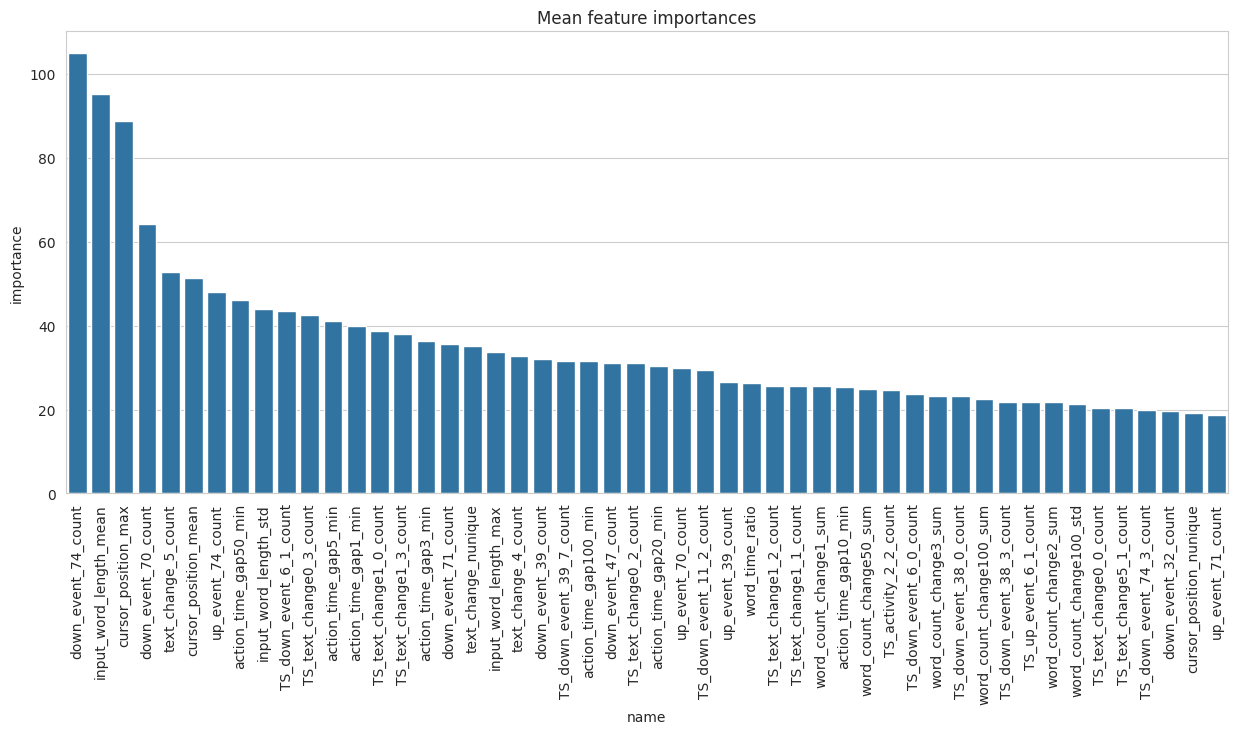

In [50]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df, x="name", y="importance")
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

# Evaluation of OOF Preds on Training Set (CV)

In [51]:
for fold in range(CONFIG.num_folds):
    print(f"Predicting the train set with FOLD {fold}")
    X_train = train_feats[train_feats["fold"] != fold][feature_names]
    Y_train = train_feats[train_feats["fold"] != fold][CONFIG.response_variate]

    X_val = train_feats[train_feats["fold"] == fold][feature_names]
    Y_val = train_feats[train_feats["fold"] == fold][CONFIG.response_variate]

    lgb_model = models_dict[fold]
    pred_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
    train_feats.loc[X_val.index, f"pred_{CONFIG.response_variate}"] = pred_val

Predicting the train set with FOLD 0
Predicting the train set with FOLD 1
Predicting the train set with FOLD 2
Predicting the train set with FOLD 3
Predicting the train set with FOLD 4


In [52]:
rmse = mean_squared_error(
    train_feats[CONFIG.response_variate],
    np.clip(train_feats[f"pred_{CONFIG.response_variate}"], a_min=0.5, a_max=6.0),
    squared=False,
)
print("CV RMSE:", rmse)
train_feats = train_feats.drop(columns=["pred_score"])

CV RMSE: 0.6369100773178725


# Predicting The Test Set

We use the mean of all the predictions for all the fold models

In [ ]:
for fold in range(CONFIG.num_folds):
    print(f"Predicting the test set with FOLD {fold}")
    X_test = test_feats[feature_names]

    lgb_model = models_dict[fold]
    pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)
    test_feats[f"pred_{CONFIG.response_variate}_fold{fold}"] = pred

test_feats[CONFIG.response_variate] = test_feats[
    [f"pred_{CONFIG.response_variate}_fold{fold}" for fold in range(CONFIG.num_folds)]
].mean(axis=1)
test_feats[CONFIG.response_variate] = np.clip(
    test_feats[CONFIG.response_variate], a_min=0.5, a_max=6.0
)

# Submission

In [ ]:
submission = test_feats[["id", CONFIG.response_variate]]
submission

In [ ]:
submission.to_csv("submission.csv", index=False)

# Thanks for reading!

# Please leave an upvote if this was helpful!